# Imports

In [1]:
import numpy
import scipy
import math
import matplotlib as mpl
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
import pytz
import multiprocessing as mpp
import pickle
import sys
import os
import pandas as pd

import hpc_lib
import hpc_reports


# Set the group and dates here

In [2]:
# Group + partition (None gives all partitions)
grp_group='smbenson'
grp_partition=None

#Specify end date and how many days back you want to go
N_report_len = 180
end_dtm = dtm.datetime(2023,10,15)
end_date = end_dtm.date()
start_date = end_date - dtm.timedelta(days=N_report_len)

# Some random parameters for computing
n_cpus = 2
delim_sacct='*'
verbose=False

# File to save results to
sacct_h5_file = f'/home/users/bchivers/HPC_analytics/sacct_data/sacct_sherlock_p{str(grp_partition).upper()}_g{str(grp_group).upper()}_u_{start_date.year:04}{start_date.month:02}{start_date.day:02}_{end_dtm.year:04}{end_dtm.month:02}{end_dtm.day:02}.h5'
print(f'*** sacct_h5_file [{os.path.isfile(sacct_h5_file)}]: {sacct_h5_file}')



*** sacct_h5_file [True]: /home/users/bchivers/HPC_analytics/sacct_data/sacct_sherlock_pNONE_gSMBENSON_u_20230418_20231015.h5


In [3]:
if os.path.isfile(sacct_h5_file):
    print('*** Creating SACCT object from HDF5 {}'.format(sacct_h5_file))
    SACCT_obj = hpc_lib.SACCT_data_from_h5(sacct_h5_file, keep_raw_data=False, n_cpu=n_cpus)
    #
    
else:
    print('*** Fetching SACCT data directly')
    SACCT_obj = hpc_lib.SACCT_data_direct(group=grp_group, partition=grp_partition, start_date=str(start_date),
                                          n_cpu=n_cpus, verbose=verbose, delim=delim_sacct,
                                          end_date=str(end_date), keep_raw_data=False)
    # , sacct_user=s_user
    print(f'** writing HDF5: {sacct_h5_file}')
    SACCT_obj.write_hdf5(sacct_h5_file)
    #
#

*** Creating SACCT object from HDF5 /home/users/bchivers/HPC_analytics/sacct_data/sacct_sherlock_pNONE_gSMBENSON_u_20230418_20231015.h5


# CPU Usage

*** DEBUG t_now: 19646.434353935012, t_max: 19646.384756944444


/home/users/bchivers/HPC_analytics/hpc_lib.py:3737: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


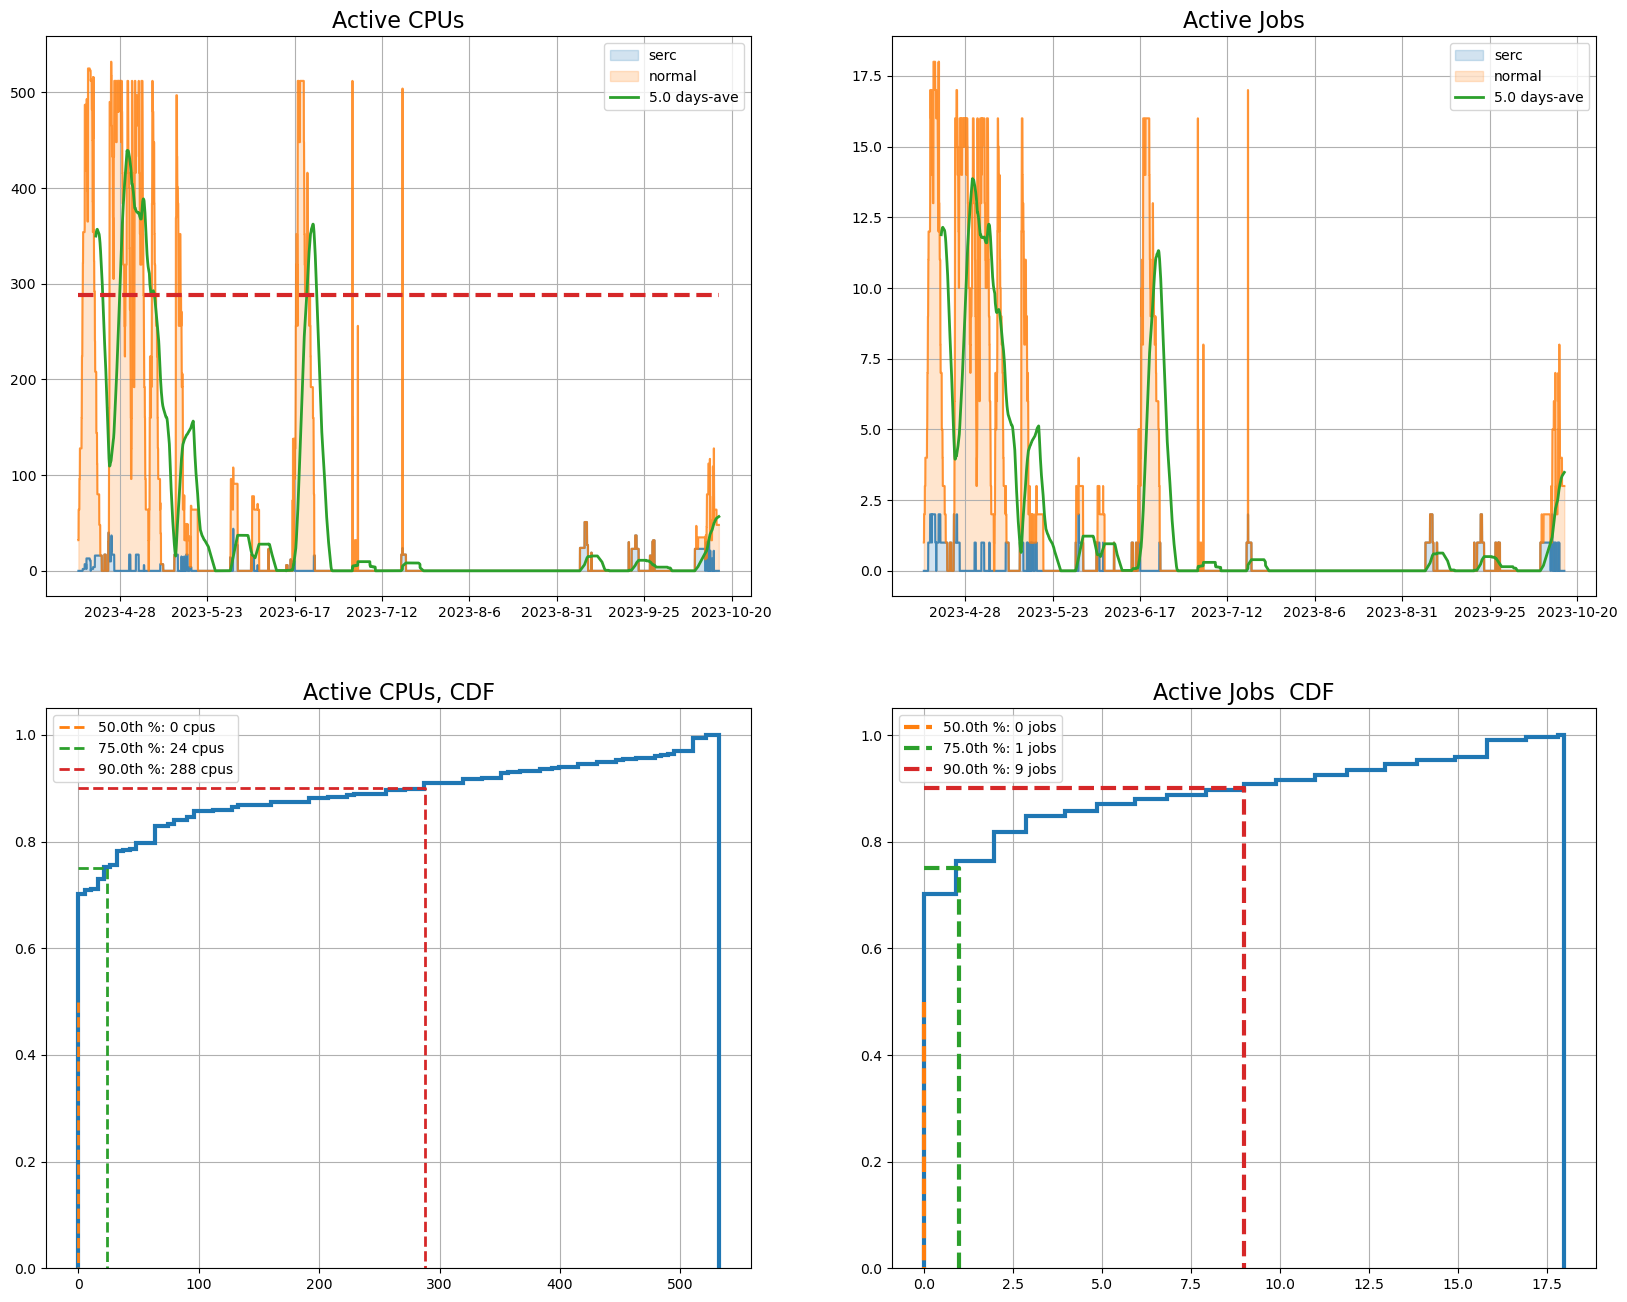

In [4]:
fg_cpu_lc_acct = SACCT_obj.report_activecpus_jobs_layercake_and_CDFs(group_by='Partition')

ax = fg_cpu_lc_acct.axes[0]
ln_ = ax.lines[0]
X = ln_.get_xdata()
#
ax.plot(X[0::(len(X)-1)], (12*24)*numpy.ones(2), ls='--', lw=3)

# Memory Usage

Text(0.5, 0, '$MaxRSS/ReqMEM$')

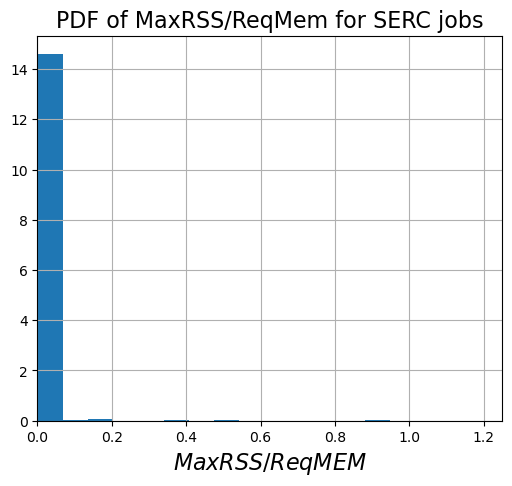

In [5]:
fg = plt.figure(figsize=(6,5))
ax = fg.add_subplot(1,1,1)
#
zz = ax.hist(SACCT_obj['MaxRSS']/SACCT_obj['ReqMem'], bins=30, density=True)
ax.set_xlim(0., 1.25)
ax.grid()
ax.set_title('PDF of MaxRSS/ReqMem for SERC jobs', size=16)
ax.set_xlabel('$MaxRSS/ReqMEM$', size=16)

In [6]:
sacct_df = pd.DataFrame(SACCT_obj.jobs_summary)

In [7]:
sacct_df['Submit'] = pd.to_datetime(sacct_df['Submit'].apply(lambda x: mpd.num2date(x)))
sacct_df['Start'] = pd.to_datetime(sacct_df['Start'].apply(lambda x: mpd.num2date(x) if x==x else numpy.nan))

In [8]:
req_mem_per_day_in_gb = sacct_df[['Submit','ReqMem']].groupby(pd.to_datetime(sacct_df.Submit).dt.date).sum()/1e9

/tmp/ipykernel_31350/3652015907.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  req_mem_per_day_in_gb = sacct_df[['Submit','ReqMem']].groupby(pd.to_datetime(sacct_df.Submit).dt.date).sum()/1e9


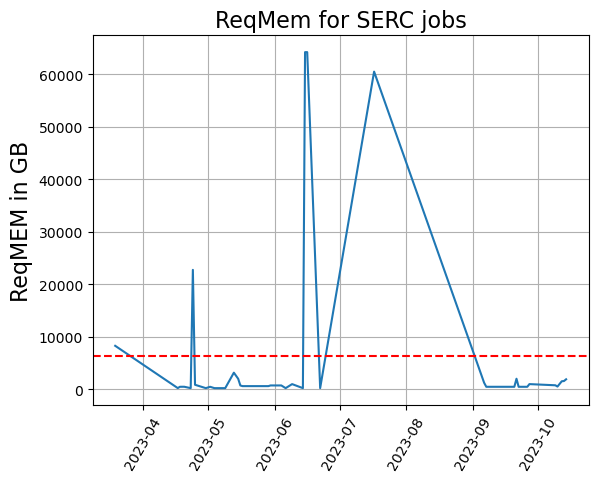

In [9]:
times = req_mem_per_day_in_gb.index
y = req_mem_per_day_in_gb

fig, ax = plt.subplots()
ax.plot(times, y)
plt.axhline(y=req_mem_per_day_in_gb.mean()[0], color='r', linestyle='--')

ax.grid()
ax.set_title('ReqMem for SERC jobs', size=16)
ax.set_ylabel('ReqMEM in GB', size=16)
plt.xticks(rotation=60)
plt.show()

# GPUs

*** DEBUG t_now: 19646.43438277125, t_max: 19646.384756944444


/home/users/bchivers/HPC_analytics/hpc_lib.py:3737: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


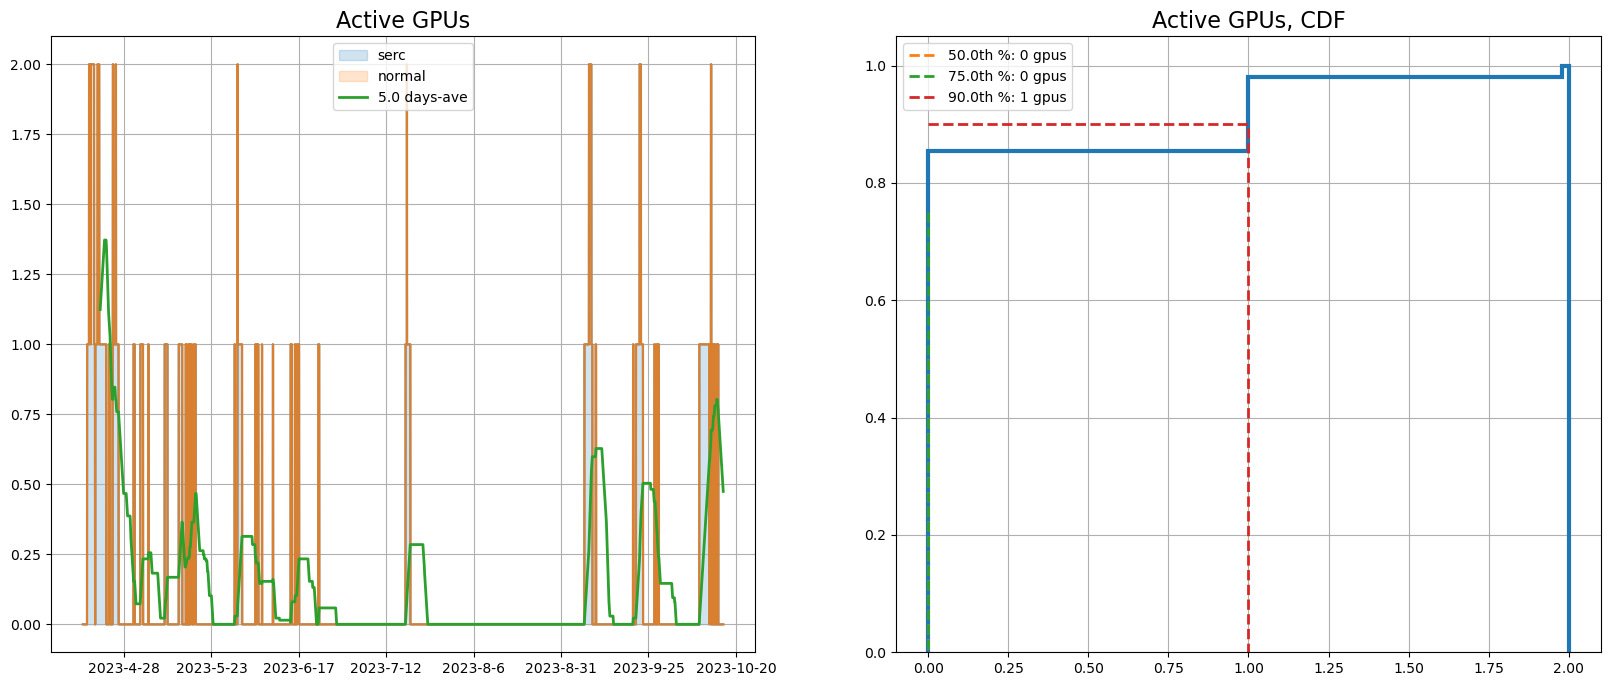

In [10]:
fg_cpu_lc_acct = SACCT_obj.report_activegpus_layercake_and_CDFs(group_by='Partition')

ax = fg_cpu_lc_acct.axes[0]
ln_ = ax.lines[0]
X = ln_.get_xdata()

In [11]:
sacct_df['ReqMemPerGPU']=sacct_df[['ReqMem','NGPUs']].apply(lambda x: x['ReqMem']/x['NGPUs'] if x['NGPUs']>0 else numpy.nan, axis=1)



Text(0.5, 0, 'ReqMEM in GB')

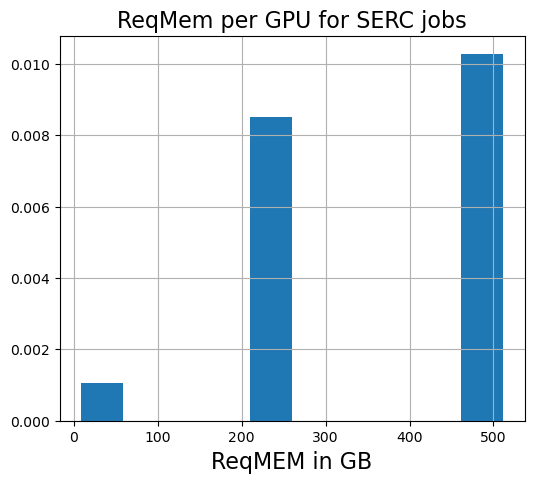

In [12]:
fg = plt.figure(figsize=(6,5))
ax = fg.add_subplot(1,1,1)
#
zz = ax.hist(sacct_df['ReqMemPerGPU']/1e9, bins=10, density=True)
ax.grid()
ax.set_title('ReqMem per GPU for SERC jobs', size=16)
ax.set_xlabel('ReqMEM in GB', size=16)

In [13]:
gpu_per_day = sacct_df[['Submit','NGPUs']].groupby(pd.to_datetime(sacct_df.Submit).dt.date).sum()['NGPUs']

/tmp/ipykernel_31350/3810101965.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gpu_per_day = sacct_df[['Submit','NGPUs']].groupby(pd.to_datetime(sacct_df.Submit).dt.date).sum()['NGPUs']


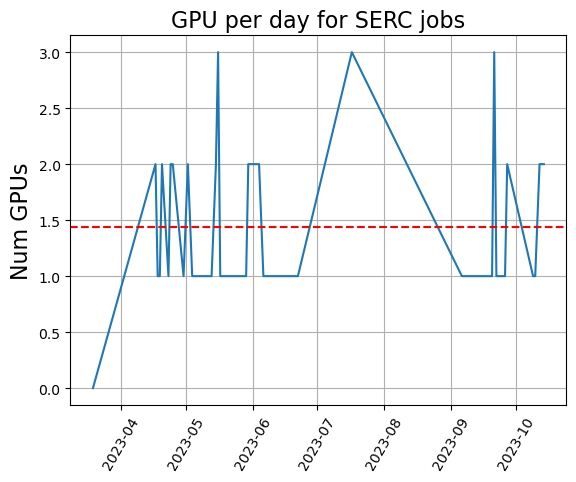

In [14]:
times = gpu_per_day.index
y = gpu_per_day

fig, ax = plt.subplots()
ax.plot(times, y)
plt.axhline(y=gpu_per_day.mean(), color='r', linestyle='--')

ax.grid()
ax.set_title('GPU per day for SERC jobs', size=16)
ax.set_ylabel('Num GPUs', size=16)
plt.xticks(rotation=60)

plt.show()

# Average num jobs and wait time

In [15]:
jobs_per_day = sacct_df[['Submit','JobID']].groupby(pd.to_datetime(sacct_df.Submit).dt.date).nunique()['JobID']

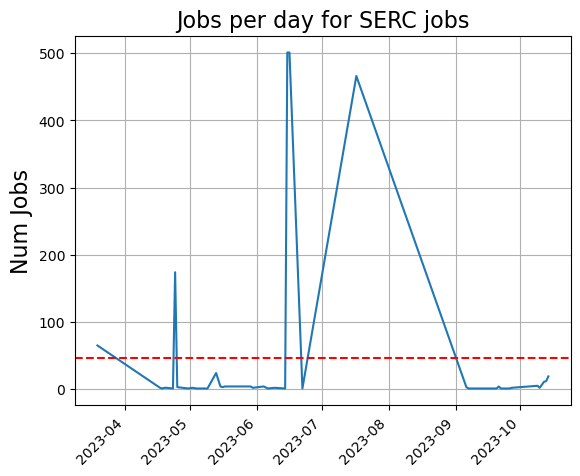

In [16]:
times = jobs_per_day.index[0:100]
y = jobs_per_day[0:100]

fig, ax = plt.subplots()
ax.plot(times, y)
plt.axhline(y=jobs_per_day.mean(), color='r', linestyle='--')

ax.grid()
ax.set_title('Jobs per day for SERC jobs', size=16)
ax.set_ylabel('Num Jobs', size=16)
plt.xticks(rotation=45, ha='right')
plt.show()

In [17]:
sacct_df['wait_time_in_seconds'] = (sacct_df['Start']-sacct_df['Submit']).dt.seconds

In [18]:
wait_time_per_day = sacct_df[['Submit','wait_time_in_seconds']].groupby(pd.to_datetime(sacct_df.Submit).dt.date).nunique()['wait_time_in_seconds']

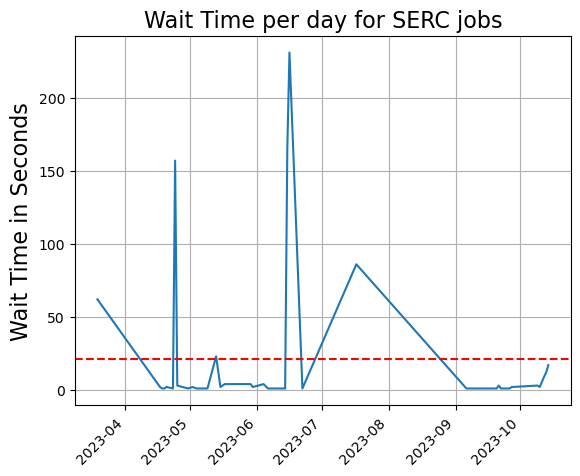

In [19]:
times = wait_time_per_day.index[0:100]
y = wait_time_per_day[0:100]

fig, ax = plt.subplots()
ax.plot(times, y)
plt.axhline(y=wait_time_per_day.mean(), color='r', linestyle='--')

ax.grid()
ax.set_title('Wait Time per day for SERC jobs', size=16)
ax.set_ylabel('Wait Time in Seconds', size=16)
plt.xticks(rotation=45, ha='right')
plt.show()